In [130]:
"""Lennard-Jones for specific atom"""

import numpy as np

class atom_props():
    def __init__(self, sigma, epsilon):
        self.sig = sigma
        self.eps = epsilon

def pot_LJ(atom,r):
    sig = atom.sig
    eps = atom.eps
    return 4*eps*((sig/r)**12 - (sig/r)**6)   

def pot_LJ_dl(r):
    r = r**-6
    u = 4*(r**2 - r)        
    return u

def grad_pot_LJ_dl(r):
    return -48*r**-13 + 24*r**-7 
    
# Initiazlize box and particles
def particle_generator(L, N, dim):
    x_init = np.random.random((dim,N))*L
    v_init = np.zeros((dim,N),dtype=float)
    return x_init, v_init

def particle_dist(L, N, x, dim):
    # Particles NN, differences, coordinates
    # Calcolate distances to NN
    r = np.zeros((N,N),dtype=float)
    delta_tot = np.zeros((dim,N,N),dtype=float)
    NN_max_dist = L/2       
    
    for i in range(dim):
        # Difference between coordinates per dimension
        delta = x[i,:]-np.transpose([x[i,:]])
        #delta = [(delta+L/2)%L - L/2] # Translated delta's
 
        # New difference including 'virtu=al' coordinates
        delta[delta >= NN_max_dist] = -(L-delta[delta >= NN_max_dist])
        delta[delta < -NN_max_dist] = (L + delta[delta < -NN_max_dist])
        
        delta_tot[i] = delta
        r += delta**2   
    r = np.sqrt(r) 
    r[r == 0] = np.inf
    return delta_tot, r

def pot_and_force(delta_tot, r, dim, N):
    # Potentials and Forces
    F = np.zeros((dim,N,N),dtype=float)
    U = 0.5*sum(pot_LJ_dl(r).sum(axis=1))
    for i in range(dim):
        F[i] = -grad_pot_LJ_dl(r)*delta_tot[i]/r
    
    F_sum = F.sum(axis=1)
    return F_sum, U

# Plotting the potential for Argon
import matplotlib.pyplot as plt
k_b = 1.38e-23
argon = atom_props(3.405e-10, k_b*119.8)        

x_t = np.linspace(0.9,5,1000)
u_t = pot_LJ_dl(x_t);

plt.plot(x_t,u_t)
plt.xlabel(r'Distance r/$\sigma$')
plt.ylabel(r'Energy u/$\epsilon$')   

In [141]:
import copy as cp
import matplotlib.pyplot as plt
# Initial positions
L = 5 # Box size
N = 10 # partciles
dim = 3 # Dimensions of the probem

x_init, v_init = particle_generator(L, N, dim) 


In [145]:

delta_t = 1e-3
t_max = 10000*delta_t

t_range = np.arange(0, t_max, delta_t)
x = cp.deepcopy(x_init)
v = cp.deepcopy(v_init)

E_kin = np.zeros((len(t_range),1), dtype=float)
E_pot = np.zeros((len(t_range),1), dtype=float)

pos = np.zeros((len(t_range),N,dim),dtype=float)

for i, t in enumerate(t_range):
    delta_tot, r = particle_dist(L, N, x, dim)
    F_tot, U_tot = pot_and_force(delta_tot, r, dim, N)
    # step_size = np.sum((abs((v * delta_t)) > 0.0005))
    x = (x + v * delta_t)%L
    v += F_tot * delta_t
   
    # 0.5 for double counting
    E_kin[i] = 0.5*(1/2*v**2).sum(axis=1).sum(axis=0)
    E_pot[i] = 0.5*U_tot.sum()
    pos[i, :, :] = x.transpose()
 

In [148]:
from IPython.display import HTML

anim = make_3d_animation(L, pos, delay=1, initial_view=(30, 20), rotate_on_play=0)
HTML(anim.to_html5_video())

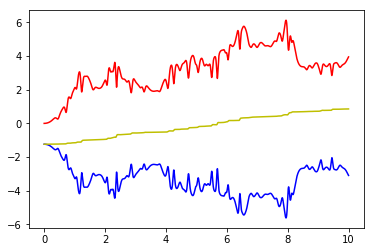

In [147]:
plt.plot(t_range,E_pot,'b')
plt.plot(t_range,E_kin,'r')
plt.plot(t_range,E_kin+E_pot,'y')
plt.show()

In [139]:
(-1.5)%2

0.5

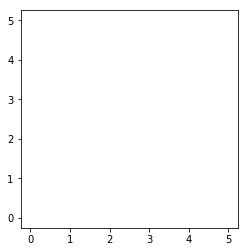

In [877]:
plt.plot(0,0)
plt.plot(L,L)
plt.axis('square')            
plt.show()


In [76]:
import numpy as np
from scipy import integrate

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

def make_3d_animation(L, pos, delay=10, initial_view=(30, 20),
                      rotate_on_play=0.5):
    """Create a matplotlib animation object to visualize
    the motion of particles in 3D.

    Parameters:
    -----------
    L: float
        size of the simulation box
    pos: array of size (n_tstep, N, 3)
        The time-dependence of the N particles. The first index of the
        array corresponds to the time.
    delay: float
        Delay between frames of the final movie in milliseconds.
        Default is 10.
    initial_view: tuple of two floats
        Initial view of the 3D box of the form (altitude degrees,
        az imuth degrees). Defaults to (30, 20).
    rotate_on_play: float
        angle (in degrees) with which the view is rotated (the azimuth
        angle is increased) by every frame. Default is 0.5.

    Results:
    --------
    anim: animation object
        Returns a matplotlib animation object. In an IPython notebook, the
        animation can be displayed as:

            from IPython.display import HTML

            anim = make_3d_animation(...)
            HTML(anim.to_html5_video())

        From a regular python script, you can call

            import matplotlib.pyplot as plt

            anim = make_3d_animation(...)
            plt.show()
    """
    # Set up figure & 3D axis for animation
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d', aspect="equal")
    ax.axis('off')

    pts = ax.plot(xs=[], ys=[], zs=[], marker="o", linestyle='None')
    
    # plot a bounding box
    ax.plot(xs=[0, L, L, 0, 0],
            ys=[0, 0, L, L, 0],
            zs=[0, 0, 0, 0, 0], color="k")
    ax.plot(xs=[0, L, L, 0, 0],
            ys=[0, 0, L, L, 0],
            zs=[L, L, L, L, L], color="k")
    ax.plot(xs=[0, 0], ys=[0, 0], zs=[0, L], color="k")
    ax.plot(xs=[0, 0], ys=[L, L], zs=[0, L], color="k")
    ax.plot(xs=[L, L], ys=[0, 0], zs=[0, L], color="k")
    ax.plot(xs=[L, L], ys=[L, L], zs=[0, L], color="k")

    # prepare the axes limits
    ax.set_xlim((0, L))
    ax.set_ylim((0, L))
    ax.set_zlim((0, L))

    # set point-of-view: specified by (altitude degrees, azimuth degrees)
    ax.view_init(*initial_view)

    # initialization function: plot the background of each frame
    def init():
        return pts

    # animation function.  This will be called sequentially with the frame number
    def animate(i):
        pts[0].set_data(pos[i, :, 0], pos[i, :, 1])
        pts[0].set_3d_properties(pos[i, :, 2])

        ax.view_init(initial_view[0], initial_view[1] + rotate_on_play * i)
        fig.canvas.draw()
        return pts

    # instantiate the animator.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(pos), interval=delay, blit=True)

    return anim
